In [1]:
#Bowerbird null model (all males are guarders)

#Key
#Notes- Paramters contain underscores, while functions don't
#SB: Stay at bower
#FG: Foraging
#MT: Maraud travel (travel to rival's bower)
#MA: Maraud action (destroy bower if absent, have antagonistic interaction in present)
#MR: Maraud return (return to own bower)
#RB: Repair own bower
#MT_vs_FG: the probability of next transition away from SB being to MT (otherwise it would be to FG)
#a=-1: denotes a staying at bower action on ticket
#a=-2: denotes a foraging action on ticket
#a=-3: denotes a female visiting action on a ticket
#a=-4: denotes travel to another male's bower
#a=-5: denotes marauding of another male's bower
#a=-6: denotes returning from another male's bower
#a=-7: denotes a bower repair action on a ticket
#target: the male/node an action is preformed on. For maurading, the target is the bird under potential attack. For mating, target is male being mated with. For other activities other then maurading and mating, owner and target are the same.
#owner: The male or female actively performing an action. For mating, the female is the owner. For all other activities, the owner is male.
#networkwriter: generates network where everybird is connected
#addtotimeline: adds tickets to timeline
#travel_times_linear_p: generates a matrix that contains the probabilities of travelling to a given a bower 
#if the relationship between distance and travel preference is linear
#improb: The probability of traveling improb_distance or less
#improb_distance: The distance at which there is only a (1-improb)% chance of choosing to travel
#lamb: lambda calculated by solving improb=1-numpy.exp(-lamb*improb_distance)
#bower_states: options are 1(bower intact) and 0 (bower destroyed-will never be the case when all guarders)
#male_states: options are 1 (male present at bower) and 0 (male absent from bower)
#fitness_states: keeps track of number of matings a given male has had
#t: time
#nodes: total number of male bowerbirds in the network
#node_dist: the node by nde matrix with distances between each node
#node_graph: matrix with individuals 1 through nodes numbered by going through each row
#tau: Length of time an activity takes. If a foraging ticket has a tau of 0.5 and occurs at t=1, then the bird is foraging for 30 minutes, at which point a SB activity will start (at t=1.5).



import math
import random
import numpy as numpy
import matplotlib.pyplot as plt


#Parameters:
t=0.0 #start at time 0
t_max=12#*4*30 #2 months in hrs (assume no nights so 12 hr = 1 day)
timeholder=0
timeline=[] #initialize the timeline
#We've moved away from using these params with expovariate (how we handle FV is still TBD)
#So THE BELOW 3 SHOULD BE COMMENTED OUT (but rn we don't want the handler funcs to yell at us)
FV_param=[1, t_max/2] #5days, tmax/3 #0.2 #nodes/0.19 #totally random
FG_param=3 #larger values lead to foraging ending earlier, because taus are smaller
SB_param=1.5 #larger values lead to bowerstay ending earlier, because taus are smaller
RB_param=.5 #made up -- takes 30mins (every time -- no distribution) to repair bower
MA_param=.1 #made up -- takes 6mins (every time -- no distribution) to maraud bower
MT_vs_FG=.05 #compared 20 feedings/day to .1 maraudings/hr
nodes=4
bower_states=[1]*nodes
male_states=[1]*nodes
fitness_states=[0]*nodes
success_rates=1
success_times=[]
recents_list=[]
max_visits=6 #STEEEEVEEEE
bird_speed=12*3600 #m/hr (12m/s)
d=150.0




# makes a ticket
def ticketgenerator(tau,t, o, a, targ):
    ticket={
        'tau': tau,
        'time': t,
        'owner': o,
        'action': a,
        'target': targ
    }
    return ticket;

#writes the edges to a network of n birds where everyone is connected to everyone else 
def networkwriter(n):
    connect=[0]*n
    for i in range(0, n): 
        a=list(range(n)) #generating a list that goes from 0 to n-1
        a.remove(i) #individual removes themselves from the network
        connect[i]=a #corresponds to the list of people person i is linked to
    return connect; #returns a list of lists with all the connections in the network


# function for determining the next time based on our rate parameters
def nexttau(action):
    x=-1
    while x<=0:
        switcher = {
            -1: numpy.random.normal(loc=.1583, scale=.09755, size=1)[0], #choose when to leave bower (generate a tau for bower stay)
            -2: numpy.random.gamma(shape=1.5, scale=5, size=1)[0]/60, #choose when to stop foraging (generate a tau for foraging)
            -3: numpy.random.uniform(FV_param[0], FV_param[1]), #FV_param... totally arbitrary so we should think about it
            -5: MA_param, #in the future we'll do something with it
            -7: RB_param #in the future we'll do something with it 
        }
        x=switcher.get(action)
        print("action")
        print(action)
        print("x value")
        print(x)
    return x
    

#adds new tickets to timeline -- Stefano, any more efficient suggestions for keeping timeline in order?
def addtotimeline(tic, timeline):
    if not timeline:
        timeline.append(tic)
    else:
        ind=len(timeline)-1
        end=0
        while (tic['time']<timeline[ind]['time'] and end==0): #moves backwards until it finds where to place the ticket based on the listed times
            ind=ind-1 
            if(ind<0):
                end=1
        ind=ind+1
        timeline.insert(ind, tic)
        
#Stay at bower ticket handler. Ticket is read, and male state changes to at bower. Can generate repair bower, foraging, or maurad travel ticket.
def SBtickethandler(SB_tic, timeline, t_max, male_states, MT_vs_FG, visit_preferences, travel_times):
    ow=SB_tic['owner'] 
    if male_states[ow]==1: #because any male who is at his bower was last repairing his bower (not coming from FG or MR) 
        bower_states[ow]=1
    male_states[ow]=1
    t=SB_tic['time']
    ta=SB_tic['tau']
    if bower_states[ow]==0: #if male returns to a destroyed bower, must repair it
        RB_tau=nexttau(-7)
        SB_tic['tau']=0
        RB_tic=ticketgenerator(RB_tau,t,ow,-7,ow) #immediately, RB_tic starts 
        addtotimeline(RB_tic, timeline)
    else:
        MT_FG_time=ta+t
        if MT_FG_time<t_max:
            decider=random.random()
            if decider<MT_vs_FG: #if transition to MT
                targ=numpy.random.choice(list(range(nodes)), p=visit_preferences[ow]) #choosing the male to maurad based on visit preferences
                MT_tau=travel_times[ow][targ]
                MT_tic=ticketgenerator(MT_tau,MT_FG_time,ow,-4, targ)
                addtotimeline(MT_tic, timeline)
            else:
                FG_tau=nexttau(-2)
                FG_tic=ticketgenerator(FG_tau,MT_FG_time,ow,-2, ow) #-2 denotes foraging action
                addtotimeline(FG_tic,timeline)

#Foraging ticket handler. Ticket read, and male state changes to no longer at bower. Generates a stay at bower ticket.
def FGtickethandler(FG_tic, timeline, t_max, male_states):
    ow=FG_tic['owner'] 
    male_states[ow]=0 #male is no longer at bower
    t=FG_tic['time']
    ta=FG_tic['tau']
    SB_time=t+ta
    SB_tau=nexttau(-1)
    if SB_time<t_max:
        SB_tic=ticketgenerator(SB_tau,SB_time,ow,-1, ow) #-1 denotes staying at bower
        addtotimeline(SB_tic,timeline)
        
#Maurad travel ticket handler. Male state changes to no longer at bower, and generates a maurad action ticket.
def MTtickethandler(MT_tic,timeline,t_max,male_states):
    ow=MT_tic['owner']
    male_states[ow]=0 #male is no longer at his bower
    targ=MT_tic['target']
    t=MT_tic['time']
    ta=MT_tic['tau']
    MA_time=t+ta
    if MA_time<t_max:
        MA_tau=nexttau(-5)
        MA_tic=ticketgenerator(MA_tau,MA_time, ow, -5, targ) #generate a maurading action ticket
        addtotimeline(MA_tic, timeline)
            
def MAtickethandler(MA_tic, timeline, t_max, male_states, bower_states, travel_times):
    ow=MA_tic['owner'] 
    targ=MA_tic['target']
    if male_states[targ]==0 and bower_states[targ]==1: #if the bower is intact and its owner is absent
        bower_states[targ]=0
    else: #in all other cases bowerbird immediately leaves
        MA_tic['tau']=0 #COMMENT! Changing tau for this ticket as we read it bc stay is cut short by bower owner's presence
    t=MA_tic['time']
    ta=MA_tic['tau']
    MR_time=t+ta
    if MR_time<t_max:
        MR_tau=travel_times[ow][targ]
        MR_tic=ticketgenerator(MR_tau,MR_time, ow, -6, targ)
        addtotimeline(MR_tic, timeline)

            
def MRtickethandler(MR_tic,timeline,t_max):
    ow=MR_tic['owner']
    targ=MR_tic['target'] #accesing the male the owner chose to maurad based on visit preferences
    t=MR_tic['time']
    ta=MR_tic['tau']
    SB_time=t+ta
    if SB_time<t_max:
        SB_tau=nexttau(-1)
        SB_tic=ticketgenerator(SB_tau,SB_time, ow, -1, ow) #generate stay at bower ticket
        addtotimeline(SB_tic, timeline)
            
def RBtickethandler(RB_tic, timeline, t_max):
    ow=RB_tic['owner']
    t=RB_tic['time']
    ta=RB_tic['tau']
    SB_time=t+ta
    if SB_time<t_max:
        SB_tau=nexttau(-1)
        SB_tic=ticketgenerator(SB_tau, SB_time, ow, -1, ow)
        addtotimeline(SB_tic, timeline)
    
def FVtickethandler(FV_tic, timeline, FV_param, t_max, male_states, fitness_states, nodes, visit_preferences, travel_times, success_rate, success_times, recents_list, max_visits):
    targ=FV_tic['target']
    ow=FV_tic['owner']
    t=FV_tic['time']
    recents_list=d["rl{0}".format(ow)]
    r=random.random()
    if bower_states[targ]==1 and male_states[targ]==1 and r<success_rate: #if the bower is intact and the male is present
        recents_list=[]
        fitness_states[targ]=fitness_states[targ]+1 #assumption: female always mates if bower is intact and male present
        success_times.append(t)
        new_FV_targ=numpy.random.choice(list(range(nodes)))
        decider=random.random() #decide whether female will mate for a second time
        if decider<.8: #half the time she'll mate again due to predation (or for the heck of it -- PJ said 4-5 matings)
            new_FV_time=t+nexttau(-3)
            if new_FV_time<t_max:
                new_FV_tic=ticketgenerator(new_FV_time-t,new_FV_time, ow, -3, new_FV_targ)
                addtotimeline(new_FV_tic, timeline)        
    else: #if female does not successfully mate
        recents_list.append(targ)
        if len(recents_list)==min(max_visits, nodes): 
            recents_list=[]
            print(recents_list)
            new_FV_targ=numpy.random.choice(list(range(nodes)))
            new_FV_time=t+nexttau(-3)
            if new_FV_time<t_max:
                new_FV_tic=ticketgenerator(new_FV_time-t,new_FV_time, ow, -3, new_FV_targ)
                addtotimeline(new_FV_tic, timeline)
        else:
            new_FV_targ=-1 #just so that the code goes into the while loop the first iteration
            while(new_FV_targ in recents_list or new_FV_targ==-1):
                new_FV_targ=numpy.random.choice(list(range(nodes)), p=visit_preferences[targ]) #choose a male based on preference (a function of distance)
            new_FV_time=t+travel_times[targ][new_FV_targ] #she goes directly to this male
            if new_FV_time<t_max:
                new_FV_tic=ticketgenerator(new_FV_time-t,new_FV_time, ow, -3, new_FV_targ)
                addtotimeline(new_FV_tic, timeline)
    return recents_list



    
    
    
#FOR LATER
#def MTtickethandler (MT_tic, timeline, )

#distance function
def travel(nodes,d,bird_speed):
    node_dist= numpy.array([[-1.0]*nodes]*nodes) #(dist in m)initialize a nodes-by-nodes matrix (1st nrows, 2nd ncols)
    sqrt_nodes=int(math.sqrt(nodes)) 
    node_graph=numpy.arange(nodes)
    node_mat=node_graph.reshape(sqrt_nodes,sqrt_nodes)
    for i in range(sqrt_nodes):
        for j in range (sqrt_nodes):
            n1=node_mat[i][j]
            for a in range(sqrt_nodes):
                for b in range(sqrt_nodes):
                    n2=node_mat[a][b]
                    if n1<n2:
                        d12=math.hypot((i-a)*d,abs(j-b)*d)
                        node_dist[n1][n2]=d12
                        node_dist[n2][n1]=d12
                    if n1==n2:
                        node_dist[n1][n2]=0
    travel_times=numpy.array([[0.0]*nodes]*nodes)
    for i in range(nodes):
        for j in range(nodes):
            travel_times[i][j]=node_dist[i][j]/bird_speed
    return [node_dist,travel_times, node_mat]





travel_mats=travel(nodes,d,bird_speed)
node_dist=travel_mats[0]
travel_times=travel_mats[1]
print(travel_mats[0].astype(int))
print(travel_mats[1])
print(travel_times)




#solve for lambda 
improb=0.99
improb_distance=800
lamb=-math.log(1-improb)/improb_distance

#will write female preference based on cumulative exponential decay (lambda=.00576)
def female_probs(node_dist, nodes, lamb):
    visit_preferences=numpy.array([[0.]*nodes]*nodes)
    for i in range(nodes):
        for j in range(nodes):
            if i!=j:
                visit_preferences[i][j]=math.exp(-lamb*node_dist[i][j])        
        visit_preferences[i]=visit_preferences[i]/sum(visit_preferences[i])
    return visit_preferences

visit_preferences=female_probs(travel_times, nodes, lamb)
#print(visit_preferences)
#print(visit_preferences[1])
print(nodes)
print(visit_preferences)

[[  0 150 150 212]
 [150   0 212 150]
 [150 212   0 150]
 [212 150 150   0]]
[[0.         0.00347222 0.00347222 0.00491046]
 [0.00347222 0.         0.00491046 0.00347222]
 [0.00347222 0.00491046 0.         0.00347222]
 [0.00491046 0.00347222 0.00347222 0.        ]]
[[0.         0.00347222 0.00347222 0.00491046]
 [0.00347222 0.         0.00491046 0.00347222]
 [0.00347222 0.00491046 0.         0.00347222]
 [0.00491046 0.00347222 0.00347222 0.        ]]
4
[[0.         0.33333425 0.33333425 0.33333149]
 [0.33333425 0.         0.33333149 0.33333425]
 [0.33333425 0.33333149 0.         0.33333425]
 [0.33333149 0.33333425 0.33333425 0.        ]]


In [2]:
#just a test

d={}
 
#the logic with ts and taus is not parallel to all other ticket types, but it seems to work... maybe change later    
for i in range(int(nodes/4)): 
    first_male=random.choice(list(range(nodes))) #The lucky bowerbird that is chosen by the female first
    first_female_time=t+nexttau(-3) #determine the time when the first female arrives
    first_female_tic=ticketgenerator(first_female_time-t,first_female_time, i, -3, first_male) #first female ticket
    addtotimeline(first_female_tic, timeline)
    d["rl{0}".format(i)]=[]
    

for i in range(nodes):
    init_SB_time=t+nexttau(-1)
    init_SB_tic=ticketgenerator(init_SB_time-t, t, i, -1, i)
    addtotimeline(init_SB_tic, timeline)
        
        
print(timeline)


action
-3
x value
3.1509148484519796
action
-1
x value
0.1941845389176934
action
-1
x value
0.18224887238771004
action
-1
x value
-0.01198827583536266
action
-1
x value
0.09551021252249352
action
-1
x value
0.13660004734533204
[{'tau': 0.1941845389176934, 'time': 0.0, 'owner': 0, 'action': -1, 'target': 0}, {'tau': 0.18224887238771004, 'time': 0.0, 'owner': 1, 'action': -1, 'target': 1}, {'tau': 0.09551021252249352, 'time': 0.0, 'owner': 2, 'action': -1, 'target': 2}, {'tau': 0.13660004734533204, 'time': 0.0, 'owner': 3, 'action': -1, 'target': 3}, {'tau': 3.1509148484519796, 'time': 3.1509148484519796, 'owner': 0, 'action': -3, 'target': 0}]


In [3]:
#while loop

while t<t_max:
    if timeholder>(len(timeline)-1): #if timeholder exceeds max timeline index
        break
    next_tic=timeline[timeholder] #look at the ticket corresponding to where we are on the timeline
    action=next_tic['action']
    ow=next_tic['owner']
    if action==-1:
        SBtickethandler(next_tic, timeline, t_max, male_states, MT_vs_FG, visit_preferences, travel_times)
    elif action==-2:
        FGtickethandler(next_tic, timeline, t_max, male_states)
    elif action==-3:
        d["rl{0}".format(ow)]=FVtickethandler(next_tic, timeline, FV_param, t_max, male_states, fitness_states, nodes, visit_preferences, travel_times, success_rates, success_times, d["rl{0}".format(ow)], max_visits)
    elif action==-4:
        MTtickethandler(next_tic,timeline,t_max,male_states)
    elif action==-5:
        MAtickethandler(next_tic, timeline, t_max, male_states, bower_states, travel_times)
    elif action==-6:
        MRtickethandler(next_tic,timeline,t_max)
    else:
        RBtickethandler(next_tic, timeline, t_max) 
    t=next_tic['time'] #new time based on the ticket we just read
    timeholder=timeholder+1 #increment timeholder

print(timeline)


action
-2
x value
0.31489647032033363
action
-2
x value
0.06036041144110901
action
-2
x value
0.19004990759843354
action
-2
x value
0.015820476679067854
action
-1
x value
0.17087390583505638
action
-1
x value
0.2272963033768532
action
-2
x value
0.07835200773447949
action
-1
x value
0.12890769645418906
action
-1
x value
0.08138998953205341
action
-2
x value
0.07993481306295516
action
-2
x value
0.08029655196207654
action
-1
x value
0.23754152548582597
action
-1
x value
0.3258243126509113
action
-2
x value
0.004084394145738397
action
-1
x value
0.25344190572707725
action
-2
x value
0.1051635776464732
action
-2
x value
0.20533092309705692
action
-2
x value
0.1522177723088631
action
-1
x value
0.2972700647669052
action
-1
x value
0.06673610172785402
action
-2
x value
0.09260300233355202
action
-1
x value
0.11794152602066094
action
-1
x value
0.030089533130677137
action
-1
x value
0.03714161786031363
action
-2
x value
0.10442262027891568
action
-2
x value
0.1293063720816844
action
-5
x val

0.0940516796664875
action
-2
x value
0.05150066951261276
action
-2
x value
0.11109268328195539
action
-1
x value
0.184921013785093
action
-1
x value
0.25190565483364036
action
-1
x value
0.17003422630292642
action
-2
x value
0.07615011929971227
action
-2
x value
0.06502065383928533
action
-2
x value
0.035489263005814675
action
-1
x value
0.12880260709527955
action
-2
x value
0.07644398128936537
action
-2
x value
0.11013218975941283
action
-1
x value
0.14708246948292464
action
-2
x value
0.06216739748485039
action
-1
x value
0.18273321735037593
action
-1
x value
0.16807056981080978
action
-1
x value
0.25264602545885145
action
-2
x value
0.1902251598333134
action
-1
x value
0.06275014124824305
action
-2
x value
0.014783164753546126
action
-2
x value
0.01591604511672461
action
-1
x value
0.3094767455849201
action
-1
x value
0.19838467915569413
action
-5
x value
0.1
action
-1
x value
0.44663696500871625
action
-2
x value
0.5915694213359965
action
-1
x value
0.08311339769518936
action
-2
x 

In [4]:
d={}


for i in range(nodes):
    d["tl{0}".format(i)]=[]
for j in range(len(timeline)):
    #for i in range(nodes):
     #   if timeline[j]['owner']==i:
    if timeline[j]['action']==-3:
        d["tl{0}".format(timeline[j]['target'])].append(timeline[j])  
    else:
        d["tl{0}".format(timeline[j]['owner'])].append(timeline[j])
    

print("tl0----")
print(d["tl0"])
print("tl1----")
print(d["tl1"])
print("tl2----")
print(d["tl2"])
print("tl3----")
print(d["tl3"])  

for i in range(nodes):
    tl=d["tl{0}".format(i)]
    l=len(tl)
    ta=[0]
    fem=[]
    for j in range(l):
        if tl[j]['action']!=-3: #female visit taus don't mean anything for the male bc she isn't necessarily coming back to the same male
            ta.append(tl[j]['time'])
        else:
            fem.append(tl[j]['time'])
    d["times{0}".format(i)]=ta
    d["fvtimes{0}".format(i)]=fem

#print("times0----")
#print(d["times0"])
#print("times1----")
#print(d["times1"])
#print("times2----")
#print(d["times2"])
#print("times3----")
#print(d["times3"]) 

#append tmax - sumoftaus to each list (so it reaches tmax exactly)
for i in range(nodes):
    d["times{0}".format(i)].append(t_max)


import csv
timess=[d["times0"],d["times1"],d["times2"],d["times3"]]
csvfile = "example_times2"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(timess)
femtimess=[]
for i in range(nodes):
    femtimess.append(d["fvtimes{0}".format(i)])

csvfile = "example_fvtimes"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(femtimess)

           
    

tl0----
[{'tau': 0.1941845389176934, 'time': 0.0, 'owner': 0, 'action': -1, 'target': 0}, {'tau': 0.31489647032033363, 'time': 0.1941845389176934, 'owner': 0, 'action': -2, 'target': 0}, {'tau': 0.08138998953205341, 'time': 0.509081009238027, 'owner': 0, 'action': -1, 'target': 0}, {'tau': 0.20533092309705692, 'time': 0.5904709987700805, 'owner': 0, 'action': -2, 'target': 0}, {'tau': 0.2972700647669052, 'time': 0.7958019218671374, 'owner': 0, 'action': -1, 'target': 0}, {'tau': 0.10442262027891568, 'time': 1.0930719866340426, 'owner': 0, 'action': -2, 'target': 0}, {'tau': 0.026904872281035858, 'time': 1.1974946069129582, 'owner': 0, 'action': -1, 'target': 0}, {'tau': 0.20686666362261588, 'time': 1.224399479193994, 'owner': 0, 'action': -2, 'target': 0}, {'tau': 0.22839140229716587, 'time': 1.43126614281661, 'owner': 0, 'action': -1, 'target': 0}, {'tau': 0.10387908501894179, 'time': 1.6596575451137758, 'owner': 0, 'action': -2, 'target': 0}, {'tau': 0.08794342709774332, 'time': 1.76

In [5]:

#Percentage times at bower not currently correct-- based on all guard!!!!
#Will recalculate in the future after changing mating to not be instantaneous

    
for i in range(nodes):
    tl=d["tl{0}".format(i)]
    l=len(tl)
    ta=[]
    accSB=0
    accFG=0
    accM=0
    accRB=0
    allacc=0
    FV_list=[]
    for j in range(l):
        if tl[j]['action']!=-3: #female visit taus don't mean anything for the male bc she isn't necessarily coming back to the same male
            ta.append(tl[j]['tau'])
            print("time according to taus is {:f}".format(allacc))
            print("time according to tickets is {:f}".format(tl[j]['time']))
            allacc+=tl[j]['tau']
            if tl[j]['action']==-1:
                accSB=accSB+tl[j]['tau']
                print("action: {:d}, tau: {:f}".format(tl[j]['action'], tl[j]['tau']))
            elif tl[j]['action']==-2:
                accFG=accFG+tl[j]['tau']
                print("action: {:d}, tau: {:f}".format(tl[j]['action'], tl[j]['tau']))
            elif tl[j]['action']==-7:
                accRB=accRB+tl[j]['tau']
                print("action: {:d}, tau: {:f}".format(tl[j]['action'], tl[j]['tau']))
            else:
                accM=accM+tl[j]['tau']  
                print("action: {:d}, tau: {:f}".format(tl[j]['action'], tl[j]['tau']))
        else:
            FV_list.append(tl[j])
    d["taus{0}".format(i)]=ta
    print("Bird {:d}'s % time at bower is {:f}".format(i, accSB/t_max)) 
    print("Bird {:d}'s % time marauding is {:f}".format(i, accM/t_max)) 
    print("Bird {:d}'s % time foraging is {:f}".format(i, accFG/t_max)) 
    print("Bird {:d}'s % time repairing bower is {:f}".format(i, accRB/t_max)) 
    print("Bird {:d}'s separate accs sum to {:f}".format(i,(accSB+accM+accFG+accRB)))
    print("Bird {:d}'s allacc is {:f}".format(i,allacc))
    print("taus0----")
    print(d["taus0"])
    print(sum(d["taus0"]))
    

    
    
print("taus0----")
#print(d["taus0"])
print(sum(d["taus0"]))
print("taus1----")
#print(d["taus1"])
print(sum(d["taus1"]))
print("taus2----")
#print(d["taus2"])
print(sum(d["taus2"]))
print("taus3----")
#print(d["taus3"]) 
print(sum(d["taus3"]))

print(d["tl0"])

#append tmax - sumoftaus to each list (so it reaches tmax exactly)
#for i in range(nodes):
#    d["taus{0}".format(i)].append(t_max-sum(d["taus{0}".format(i)]))

    
#print(sum(d["taus0"]))
#print(sum(d["taus1"]))
#print(sum(d["taus2"]))
#print(sum(d["taus3"]))  

time according to taus is 0.000000
time according to tickets is 0.000000
action: -1, tau: 0.194185
time according to taus is 0.194185
time according to tickets is 0.194185
action: -2, tau: 0.314896
time according to taus is 0.509081
time according to tickets is 0.509081
action: -1, tau: 0.081390
time according to taus is 0.590471
time according to tickets is 0.590471
action: -2, tau: 0.205331
time according to taus is 0.795802
time according to tickets is 0.795802
action: -1, tau: 0.297270
time according to taus is 1.093072
time according to tickets is 1.093072
action: -2, tau: 0.104423
time according to taus is 1.197495
time according to tickets is 1.197495
action: -1, tau: 0.026905
time according to taus is 1.224399
time according to tickets is 1.224399
action: -2, tau: 0.206867
time according to taus is 1.431266
time according to tickets is 1.431266
action: -1, tau: 0.228391
time according to taus is 1.659658
time according to tickets is 1.659658
action: -2, tau: 0.103879
time accor

action: -2, tau: 0.004084
time according to taus is 0.693078
time according to tickets is 0.693078
action: -1, tau: 0.066736
time according to taus is 0.759814
time according to tickets is 0.759814
action: -2, tau: 0.092603
time according to taus is 0.852417
time according to tickets is 0.852417
action: -1, tau: 0.117942
time according to taus is 0.970358
time according to tickets is 0.970358
action: -2, tau: 0.129306
time according to taus is 1.099665
time according to tickets is 1.099665
action: -1, tau: 0.013314
time according to taus is 1.112979
time according to tickets is 1.112979
action: -2, tau: 0.086658
time according to taus is 1.199637
time according to tickets is 1.199637
action: -1, tau: 0.000000
time according to taus is 1.199637
time according to tickets is 1.199637
action: -7, tau: 0.500000
time according to taus is 1.699637
time according to tickets is 1.699637
action: -1, tau: 0.196073
time according to taus is 1.895710
time according to tickets is 1.895710
action: -2

time according to tickets is 6.612689
action: -1, tau: 0.195804
time according to taus is 6.808493
time according to tickets is 6.808493
action: -2, tau: 0.384414
time according to taus is 7.192907
time according to tickets is 7.192907
action: -1, tau: 0.049146
time according to taus is 7.242052
time according to tickets is 7.242052
action: -2, tau: 0.381557
time according to taus is 7.623609
time according to tickets is 7.623609
action: -1, tau: 0.121198
time according to taus is 7.744807
time according to tickets is 7.744807
action: -2, tau: 0.053485
time according to taus is 7.798292
time according to tickets is 7.798292
action: -1, tau: 0.093326
time according to taus is 7.891618
time according to tickets is 7.891618
action: -2, tau: 0.069961
time according to taus is 7.961580
time according to tickets is 7.961580
action: -1, tau: 0.132336
time according to taus is 8.093916
time according to tickets is 8.093916
action: -2, tau: 0.136426
time according to taus is 8.230342
time accor

action: -1, tau: 0.118771
time according to taus is 11.872213
time according to tickets is 11.872213
action: -2, tau: 0.068108
time according to taus is 11.940321
time according to tickets is 11.940321
action: -1, tau: 0.155157
Bird 3's % time at bower is 0.575936
Bird 3's % time marauding is 0.011227
Bird 3's % time foraging is 0.420794
Bird 3's % time repairing bower is 0.000000
Bird 3's separate accs sum to 12.095478
Bird 3's allacc is 12.095478
taus0----
[0.1941845389176934, 0.31489647032033363, 0.08138998953205341, 0.20533092309705692, 0.2972700647669052, 0.10442262027891568, 0.026904872281035858, 0.20686666362261588, 0.22839140229716587, 0.10387908501894179, 0.08794342709774332, 0.10244311426431346, 0.07906316842452436, 0.07920174681066404, 0.4417510110735727, 0.03637233765891166, 0.26511064111459176, 0.20651492574669209, 0.18621479623269338, 0.22441231961280683, 0.19382828106029176, 0.11381514283230725, 0.07819306454716093, 0.083625905737436, 0.15010609193913607, 0.2515493567956

In [6]:
print(success_times)

[3.1509148484519796, 7.061714451582668]


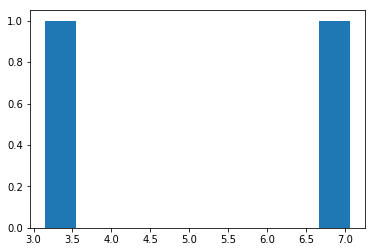

In [7]:
plt.hist(success_times)
plt.show()

In [8]:
print(len(femtimess))
#print(femtimess)
fts = [item for sublist in femtimess for item in sublist]
print(len(fts))

4
4


In [9]:
print(fitness_states)



[2, 0, 0, 0]
